# Paper Figures

In [82]:
import h5py
import os

best_margins_gudb = []
snr_list_gudb = []
local_snr_list_gudb = []

best_margins_mit_bih_af = []
snr_list_mit_bih_af = []
local_snr_list_mit_bih_af = []

best_margins_deepbeat = []
snr_list_deepbeat = []
local_snr_list_deepbeat = []

for path, _, files in os.walk(r"results/psqi_hyperparameter_experiment"):
    for file in files:
        if not file.endswith(".h5"):
            continue
        if("gudb" in file):
            best_margins_gudb.append([])
            snr_list_gudb.append([])
            local_snr_list_gudb.append(float(path.split("/")[-2].split("_")[-1]))
        elif("mit" in file):
            best_margins_mit_bih_af.append([])
            snr_list_mit_bih_af.append([])
            local_snr_list_mit_bih_af.append(float(path.split("/")[-2].split("_")[-1]))
        else:
            best_margins_deepbeat.append([])
            snr_list_deepbeat.append([])
            local_snr_list_deepbeat.append(float(path.split("/")[-2].split("_")[-1]))
        with h5py.File(os.path.join(path, file), "r") as f:
            for dataset in f.keys():
                if("snr" not in dataset):
                    continue
                if("gudb" in file):
                    best_margins_gudb[-1].append(f[dataset].attrs["best_margin"])
                    snr_list_gudb[-1].append(float(dataset.split("_")[-1]))
                elif("mit" in file):
                    best_margins_mit_bih_af[-1].append(f[dataset].attrs["best_margin"])
                    snr_list_mit_bih_af[-1].append(float(dataset.split("_")[-1]))
                else:
                    best_margins_deepbeat[-1].append(f[dataset].attrs["best_margin"])
                    snr_list_deepbeat[-1].append(float(dataset.split("_")[-1]))

print(best_margins_gudb)
print(snr_list_gudb)
print(local_snr_list_gudb)

[[np.float64(0.08752056390292384), np.float64(0.12026532599750428), np.float64(0.20306157270819303), np.float64(0.18380609634562084), np.float64(0.1854263597789917), np.float64(0.1577804534204923), np.float64(0.1817964097847209), np.float64(0.08452184305643129), np.float64(0.0780676236979847)], [np.float64(0.1534432639535095), np.float64(0.19317879004932736), np.float64(0.14825760463606819), np.float64(0.17670858495496555), np.float64(0.17670858495496555), np.float64(0.1636211340082726), np.float64(0.12546527418714826), np.float64(0.11121883231300045), np.float64(0.19459357130942978)], [np.float64(0.15220397703550714), np.float64(0.17433135475994455), np.float64(0.21325612956982243), np.float64(0.18396828757766004), np.float64(0.18678051701532383), np.float64(0.1653490202584963), np.float64(0.16214577913070716), np.float64(0.10345528702371554), np.float64(0.15452157377423648)], [np.float64(0.05096626489082057), np.float64(0.1788942354646308), np.float64(0.1772056415627189), np.float64(

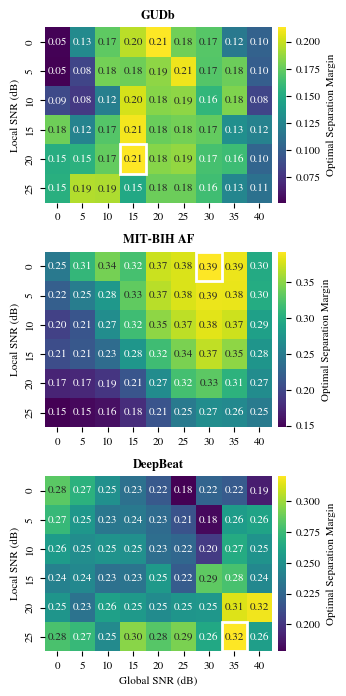

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 8

def plot_hyperparameter_heatmaps(datasets_info):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(3.5, 7))
    
    for i, (title, margins, g_snrs, l_snrs) in enumerate(datasets_info):
        data_rows = []
        for j in range(len(l_snrs)):
            local_val = l_snrs[j]
            for k in range(len(g_snrs[j])):
                data_rows.append({
                    "Local SNR": int(local_val),
                    "Global SNR": int(g_snrs[j][k]),
                    "Margin": margins[j][k]
                })
        
        df = pd.DataFrame(data_rows)
        pivot_df = df.pivot(index="Local SNR", columns="Global SNR", values="Margin")
        
        sns.heatmap(
            pivot_df, 
            ax=axes[i], 
            cmap="viridis",
            cbar=True,
            cbar_kws={'label': 'Optimal Separation Margin', 'pad': 0.02}, 
            xticklabels=True, 
            yticklabels=True,
            annot=True,
            fmt='.2f'
        )
        
        axes[i].set_title(title, fontsize=9, fontweight='bold')
        axes[i].set_ylabel("Local SNR (dB)")

        max_val = pivot_df.values.max()
        y_indices, x_indices = np.where(pivot_df.values == max_val)
        best_y, best_x = y_indices[0], x_indices[0]
        
        axes[i].add_patch(Rectangle((best_x, best_y), 1, 1, 
                                     fill=False, edgecolor='white', 
                                     lw=2, linestyle='-'))

        axes[i].set_title(title, fontsize=9, fontweight='bold')
        axes[i].set_ylabel("Local SNR (dB)")
        
        if i == 2:
            axes[i].set_xlabel("Global SNR (dB)")
        else:
            axes[i].set_xlabel("")

    plt.tight_layout()
    plt.savefig(r"results/psqi_hyperparameter_experiment/best_margin_over_snr.pdf", bbox_inches="tight", transparent=True)
    plt.savefig(r"results/psqi_hyperparameter_experiment/best_margin_over_snr.svg", bbox_inches="tight", transparent=True)
    plt.show()

datasets_to_plot = [
    ("GUDb", best_margins_gudb, snr_list_gudb, local_snr_list_gudb),
    ("MIT-BIH AF", best_margins_mit_bih_af, snr_list_mit_bih_af, local_snr_list_mit_bih_af),
    ("DeepBeat", best_margins_deepbeat, snr_list_deepbeat, local_snr_list_deepbeat)
]

plot_hyperparameter_heatmaps(datasets_to_plot)

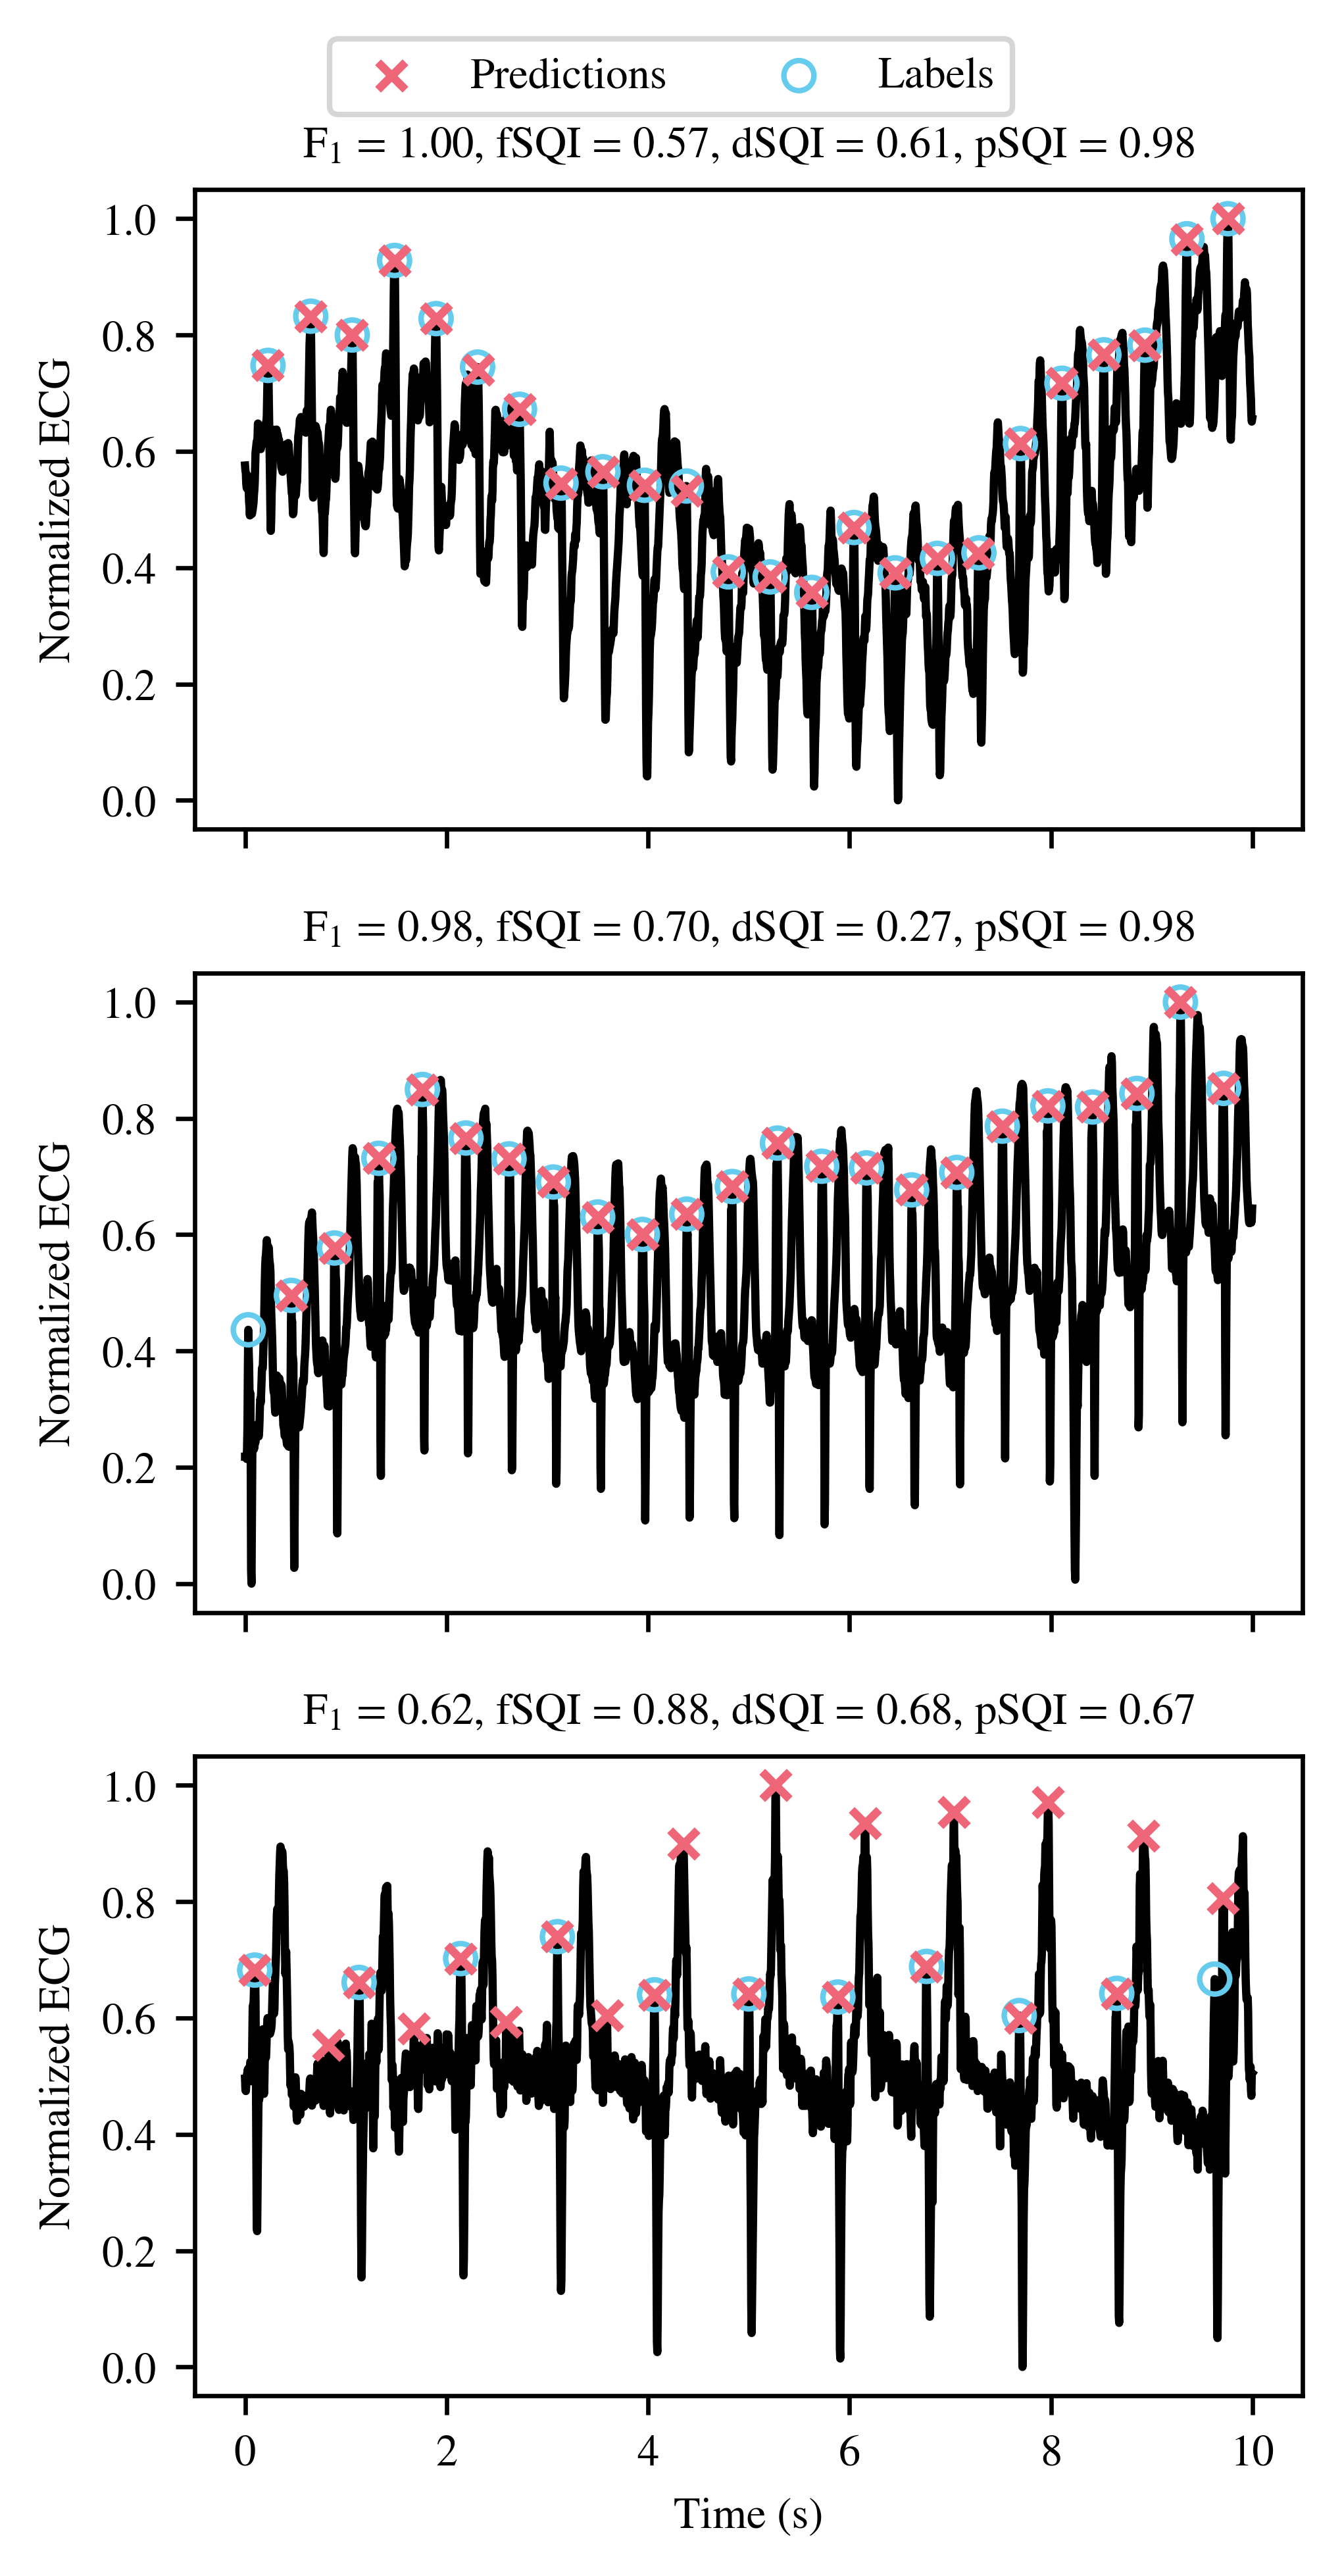

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from medsqi.datasets.gudb import load_gudb, fs
import h5py
from vg_beat_detectors.fast_nvg import FastNVG

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"

nvg = FastNVG(sampling_frequency=fs)
# Plot worst SQI samples
with h5py.File("results/peak_detection_experiment/results/results.h5", "r") as f:
    fsqi = f["feature_model_preds"][:].astype(float)
    dlsqi = f["dl_model_preds"][:].astype(float)
    psqi = f["psqi_preds"][:].astype(float)
    metrics = f["metrics"][:].astype(float)

ecgs, annos = load_gudb(data_path="/home/jhaidamous/CorruptedECGDatasets/gudb/docs/experiment_data")
idx_sorted_psqi = np.argsort(psqi)
idx_sorted_dlsqi = np.argsort(dlsqi)
idx_sorted_fsqi = np.argsort(fsqi)
t = np.arange(ecgs.shape[1]) / fs

fig, axes = plt.subplots(dpi=600, figsize=(3.5, 2.5*2.5), nrows=3, ncols=1, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    if(i == 0):
        idx = idx_sorted_fsqi[0]
    elif(i == 1):
        idx = idx_sorted_dlsqi[0]
    else:
        idx = idx_sorted_psqi[0]
    peaks = nvg.find_peaks(ecgs[idx])
    ecg_normalized = (ecgs[idx]-np.min(ecgs[idx])) / (np.max(ecgs[idx]) - np.min(ecgs[idx]))   
    ax.plot(t, ecg_normalized, color="black")
    ax.scatter(peaks / fs, ecg_normalized[peaks], marker="x", color="#EE6677", zorder=4, label="Predictions", s=25)
    ax.scatter(annos[idx] / fs, ecg_normalized[annos[idx]], marker="o", color="#66CCEE", zorder=3, label="Labels", facecolors='none', s=30, linewidths=1)
    ax.set_ylabel("Normalized ECG", fontsize=8)
    ax.set_title("$\mathrm{F}_1$" + f" = {metrics[idx]:.2f}, fSQI = {fsqi[idx]:.2f}, dSQI = {dlsqi[idx]:.2f}, pSQI = {psqi[idx]:.2f}", fontsize=8)
    ax.tick_params(labelsize=8)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=8)
plt.tight_layout()
plt.xlabel("Time (s)", fontsize=8)
plt.subplots_adjust(top=0.95)
plt.savefig("results/peak_detection_experiment/results/worst_ecgs_peak_detection.pdf", transparent=True, bbox_inches="tight")
plt.savefig("results/peak_detection_experiment/results/worst_ecgs_peak_detection.svg", transparent=True, bbox_inches="tight")    
plt.show()

25


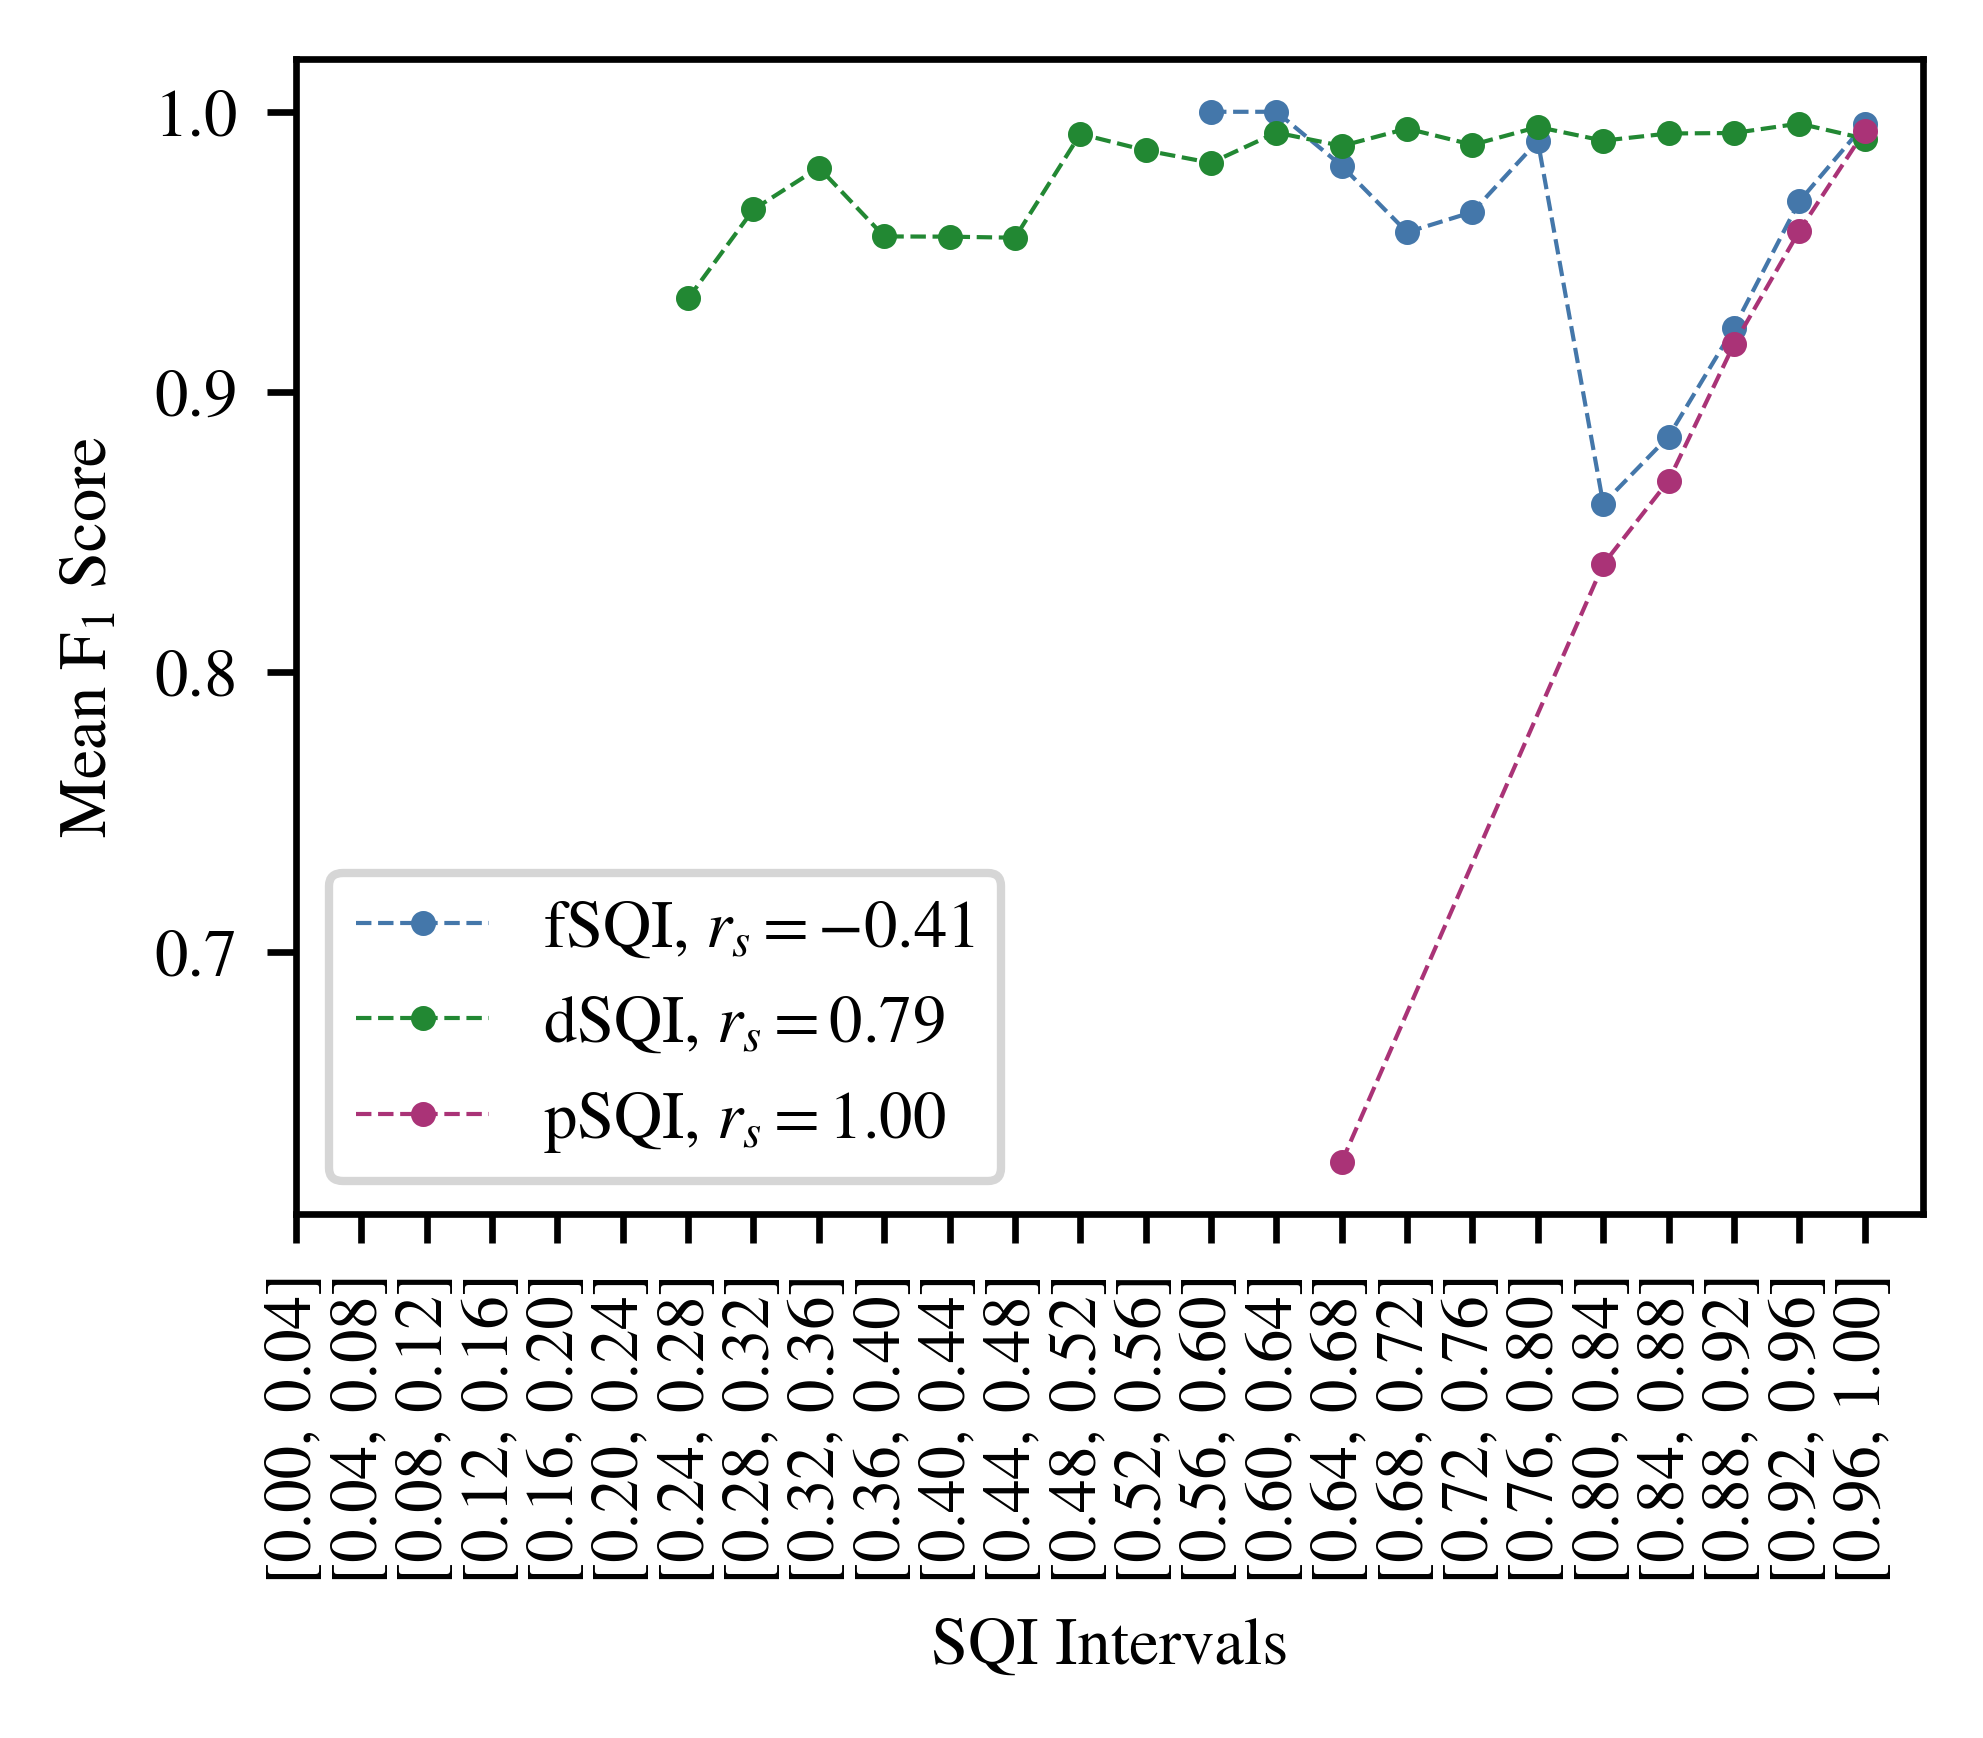

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic, spearmanr
import h5py

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"

with h5py.File("results/peak_detection_experiment/results/results.h5", "r") as f:
    fsqi = f["feature_model_preds"][:].astype(float)
    dlsqi = f["dl_model_preds"][:].astype(float)
    psqi = f["psqi_preds"][:].astype(float)
    metrics = f["metrics"][:].astype(float)   

bins = np.linspace(0, 1, 26)

stats_f, edges, _ = binned_statistic(fsqi, metrics, statistic='mean', bins=bins)
stats_dl, edges, _ = binned_statistic(dlsqi, metrics, statistic='mean', bins=bins)
stats_psqi, edges, _ = binned_statistic(psqi, metrics, statistic='mean', bins=bins)

centers = (edges[:-1] + edges[1:]) / 2
print(len(centers))
plt.figure(dpi=600, figsize=(3.5, 2.5))
plt.plot(centers[np.isfinite(stats_f)], stats_f[np.isfinite(stats_f)], "--o", label=f"fSQI, $r_s={spearmanr(centers[np.isfinite(stats_f)], stats_f[np.isfinite(stats_f)])[0]:.2f}$", color="#4477AA", linewidth=0.5, ms=2)
plt.plot(centers[np.isfinite(stats_dl)], stats_dl[np.isfinite(stats_dl)], "--o", label=f"dSQI, $r_s={spearmanr(centers[np.isfinite(stats_dl)], stats_dl[np.isfinite(stats_dl)])[0]:.2f}$", color="#228833", linewidth=0.5, ms=2)
plt.plot(centers[np.isfinite(stats_psqi)], stats_psqi[np.isfinite(stats_psqi)], "--o", label=f"pSQI, $r_s={spearmanr(centers[np.isfinite(stats_psqi)], stats_psqi[np.isfinite(stats_psqi)])[0]:.2f}$", color="#AA3377", linewidth=0.5, ms=2)
plt.xlabel("SQI Intervals", fontsize=8)
plt.xticks(centers, [f"[{edges[i]:.2f}, {edges[i+1]:.2f}]" for i in range(len(centers))], rotation=90, fontsize=8)
plt.ylabel("Mean $\mathrm{F}_1$ Score", fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.savefig(r"results/peak_detection_experiment/results/bin_plot_line.pdf", bbox_inches="tight", transparent=True)
plt.savefig(r"results/peak_detection_experiment/results/bin_plot_line.svg", bbox_inches="tight", transparent=True)
plt.show()

# README R-Peak Figure

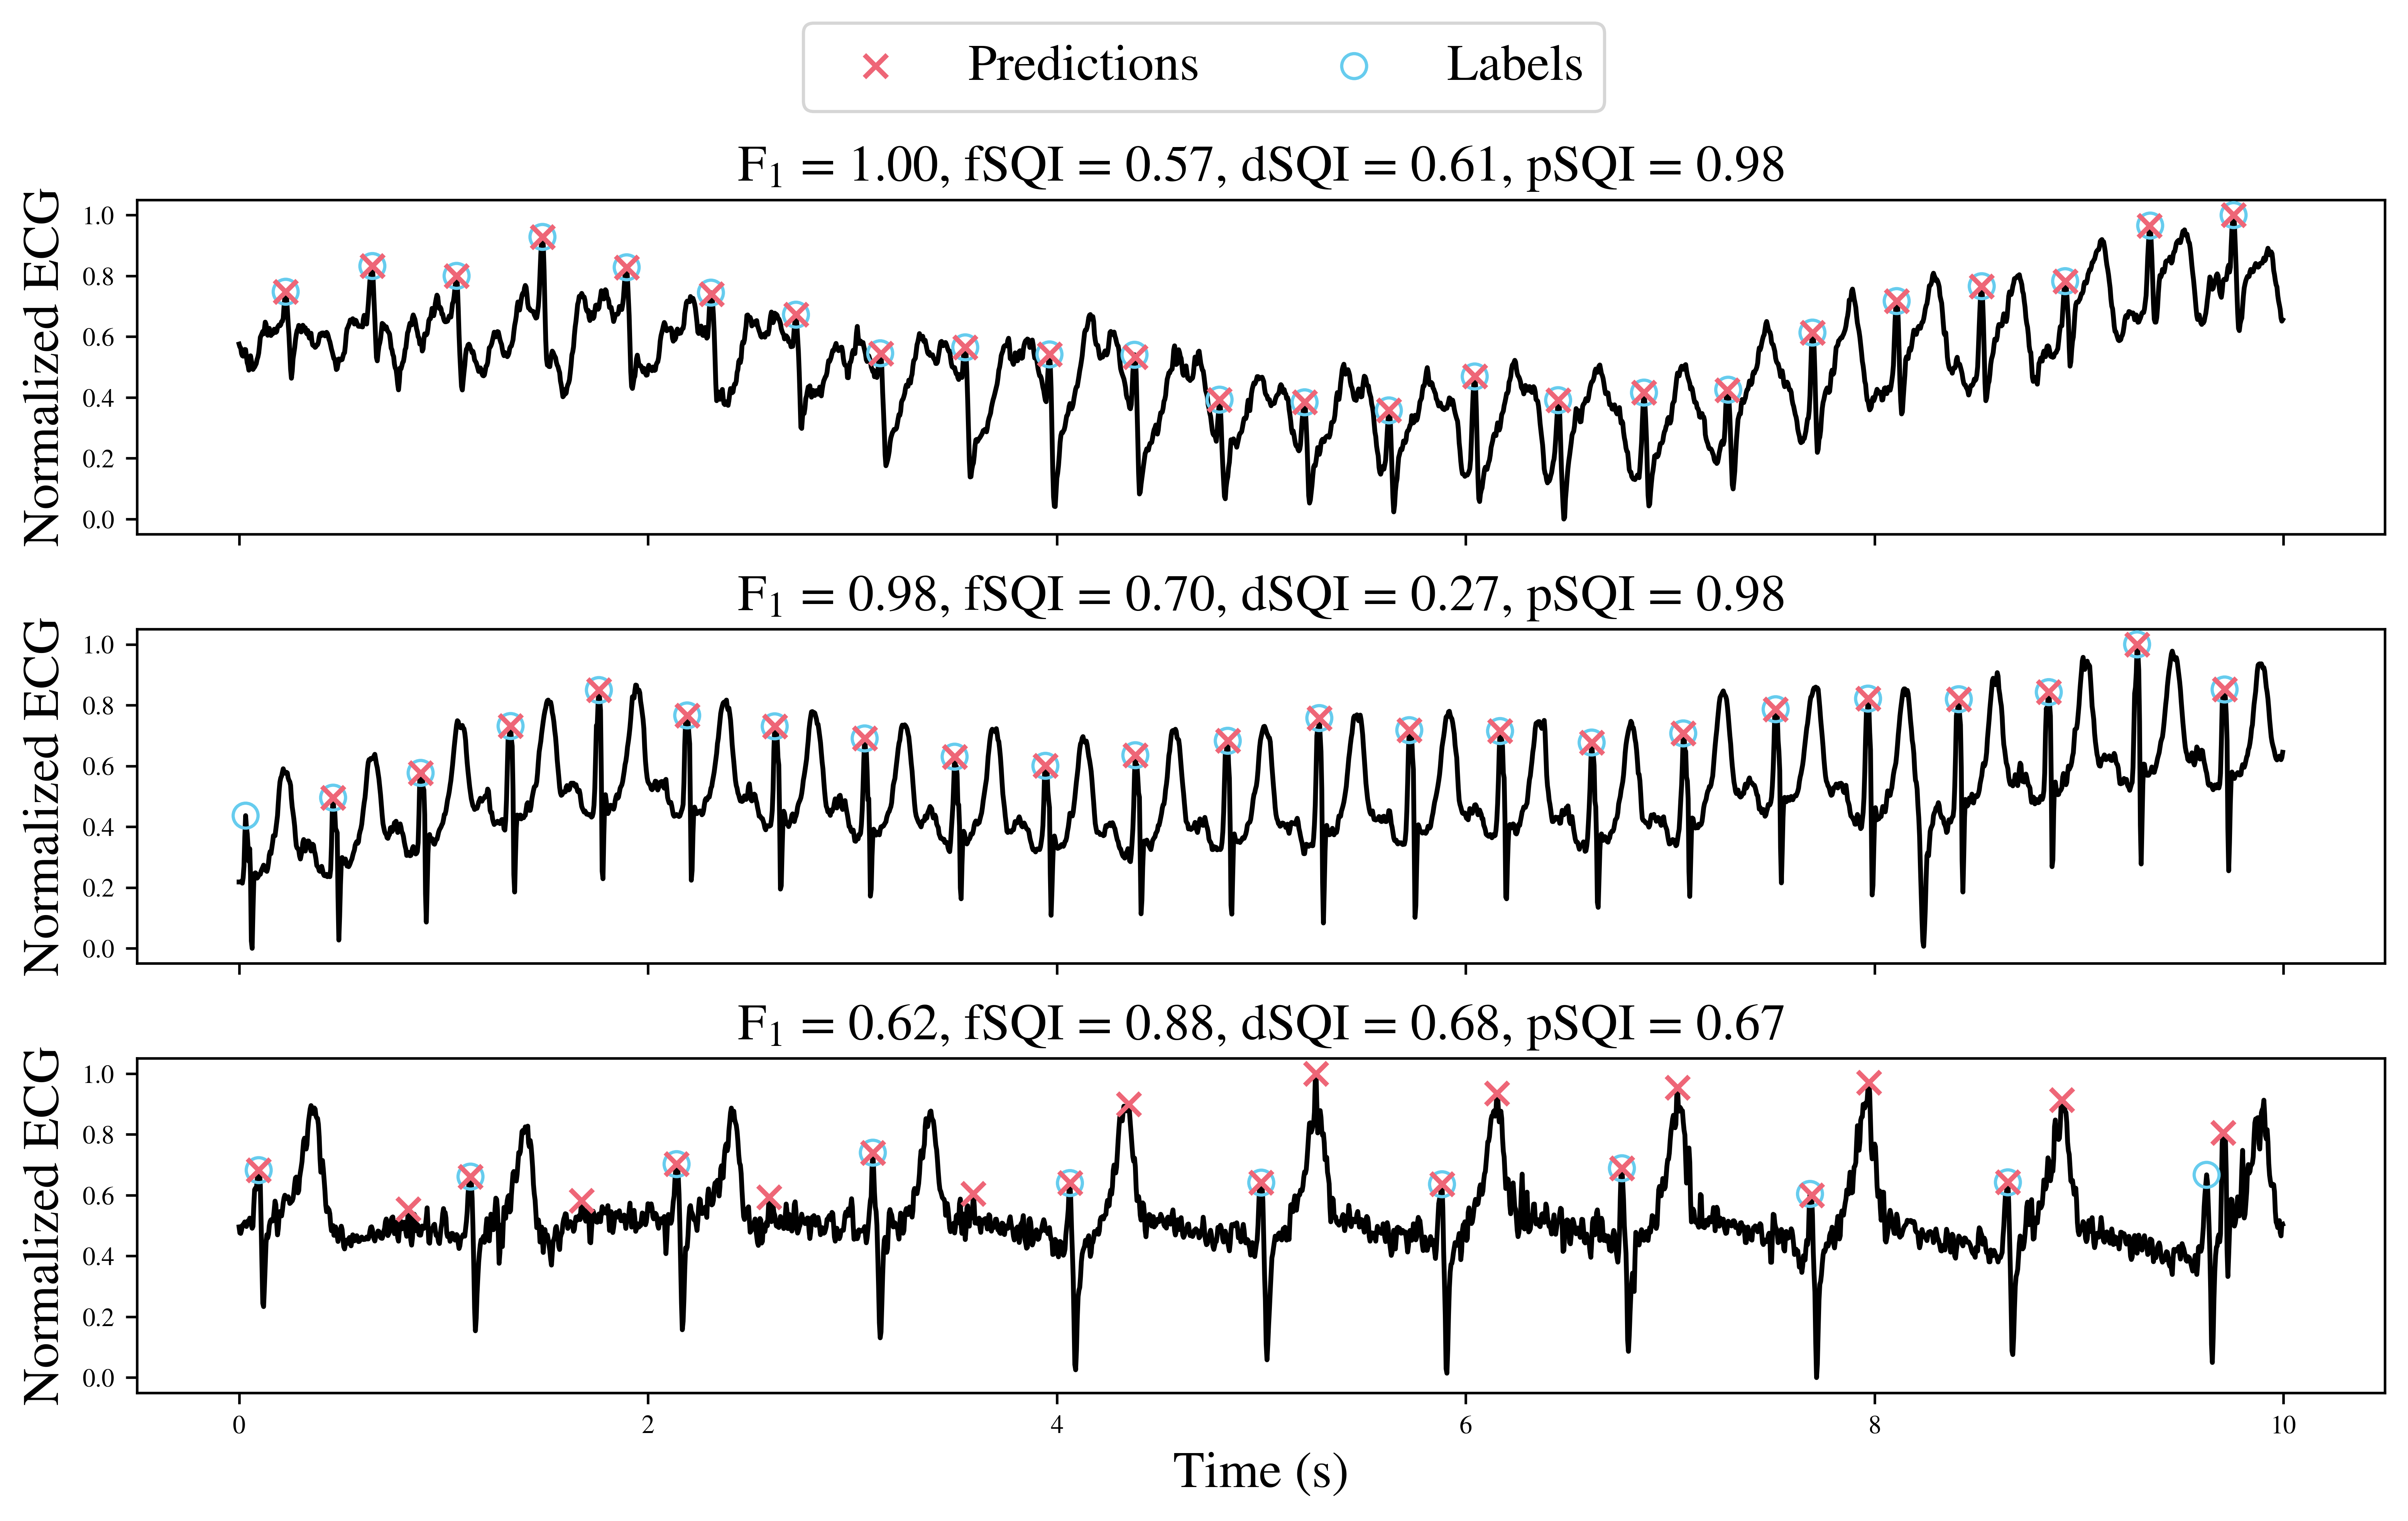

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from medsqi.datasets.gudb import load_gudb, fs
import h5py
from vg_beat_detectors.fast_nvg import FastNVG

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"

nvg = FastNVG(sampling_frequency=fs)
# Plot worst SQI samples
with h5py.File("results/peak_detection_experiment/results/results.h5", "r") as f:
    fsqi = f["feature_model_preds"][:].astype(float)
    dlsqi = f["dl_model_preds"][:].astype(float)
    psqi = f["psqi_preds"][:].astype(float)
    metrics = f["metrics"][:].astype(float)

ecgs, annos = load_gudb(data_path="/home/jhaidamous/CorruptedECGDatasets/gudb/docs/experiment_data")
idx_sorted_psqi = np.argsort(psqi)
idx_sorted_dlsqi = np.argsort(dlsqi)
idx_sorted_fsqi = np.argsort(fsqi)
t = np.arange(ecgs.shape[1]) / fs

fig, axes = plt.subplots(dpi=600, figsize=(3.5*3, 2.5*2.5), nrows=3, ncols=1, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    if(i == 0):
        idx = idx_sorted_fsqi[0]
    elif(i == 1):
        idx = idx_sorted_dlsqi[0]
    else:
        idx = idx_sorted_psqi[0]
    peaks = nvg.find_peaks(ecgs[idx])
    ecg_normalized = (ecgs[idx]-np.min(ecgs[idx])) / (np.max(ecgs[idx]) - np.min(ecgs[idx]))   
    ax.plot(t, ecg_normalized, color="black")
    ax.scatter(peaks / fs, ecg_normalized[peaks], marker="x", color="#EE6677", zorder=4, label="Predictions", s=50)
    ax.scatter(annos[idx] / fs, ecg_normalized[annos[idx]], marker="o", color="#66CCEE", zorder=3, label="Labels", facecolors='none', s=60, linewidths=1)
    ax.set_ylabel("Normalized ECG", fontsize=16)
    ax.set_title("$\mathrm{F}_1$" + f" = {metrics[idx]:.2f}, fSQI = {fsqi[idx]:.2f}, dSQI = {dlsqi[idx]:.2f}, pSQI = {psqi[idx]:.2f}", fontsize=16)
    ax.tick_params(labelsize=8)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=16)
plt.tight_layout()
plt.xlabel("Time (s)", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.savefig("worst_ecgs_peak_detection_readme.svg", transparent=False, bbox_inches="tight")    
plt.show()